In [ ]:
!pip install lazypredict

In [3]:
import numpy as np
import pandas as pd
import sys
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import sklearn
import lazypredict
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange
import itertools
from sklearn.impute import KNNImputer

In [4]:
df_train = pd.read_csv('../DATA/train_airbnb_berlin.xls')

# without label
#df_validation = pd.read_csv('./test_airbnb_berlin.xls') 

# Pre processing

### Feature analysis

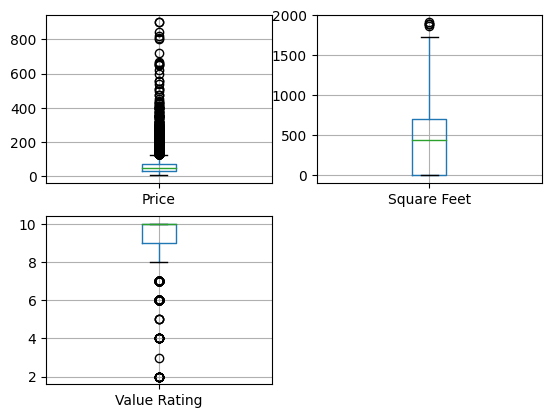

In [4]:
plt.subplot(221)
df_train.boxplot(column='Price')

plt.subplot(222)
df_train.boxplot(column='Square Feet')

plt.subplot(223)
df_train.boxplot(column='Value Rating')

plt.show()

In [40]:
def compress_postal_code(df_train : pd.DataFrame):
    df_train['Postal Code'].value_counts()
    zip_code = []
    for i in df_train['Postal Code']:
        i = str(i)
        zip_code.append(i[:3])
    
    zip = pd.DataFrame({'Compressed zip': zip_code})
    print(zip)
    return zip

In [41]:
compressed_zip = compress_postal_code(df_train)

      Compressed zip
0                104
1                131
2                104
3                102
4                104
...              ...
15687            109
15688            120
15689            133
15690            121
15691            103

[15692 rows x 1 columns]


In [38]:
def percentage_of_nans(df: pd.DataFrame) -> list:
    nan_percentage = pd.DataFrame(columns=['Feature Name', 'Percentage of NaNs'])
    for idx, feature in enumerate(df.columns):
        notnans = df_train[feature].notna().value_counts()
        percentage = 0
        if False in notnans:
            percentage = int(10000*notnans[False]/len(df_train))/100

        nan_percentage.loc[idx] = [feature, percentage]
    return nan_percentage

In [4]:
nan_percentage = percentage_of_nans(df_train)
df = nan_percentage[nan_percentage['Percentage of NaNs'] != 0]
df.sort_values(by=['Percentage of NaNs'], ascending=False)

,Feature Name,Percentage of NaNs
23,Square Feet,98.06
5,Host Response Time,45.08
6,Host Response Rate,45.08
32,Checkin Rating,18.94
35,Value Rating,18.93
34,Location Rating,18.93
30,Accuracy Rating,18.93
33,Communication Rating,18.92
31,Cleanliness Rating,18.92
29,Overall Rating,18.87


In [54]:
df_train['Neighborhood Group'].value_counts()

Friedrichshain-Kreuzberg    3768
Mitte                       3174
Pankow                      2473
NeukÃ¶lln                   2470
Tempelhof - SchÃ¶neberg     1081
Charlottenburg-Wilm.        1065
Lichtenberg                  520
Treptow - KÃ¶penick          435
Steglitz - Zehlendorf        302
Reinickendorf                218
Marzahn - Hellersdorf        127
Spandau                       59
Name: Neighborhood Group, dtype: int64

### Data cleaning

In [22]:

def replace_na(df : pd.DataFrame, numerical_variables : list()):
    df.replace(['f', 't'], [0, 1], inplace=True)
    df.replace(["*", 'nan'], [np.NaN, np.NaN], inplace=True)
    
    imputer = KNNImputer(n_neighbors=2)
    imputed_values = imputer.fit_transform(df[numerical_variables])
    df[numerical_variables] = pd.DataFrame(imputed_values, columns=numerical_variables)

    # for column in numerical_variables:
    #     df[column] = pd.to_numeric(df[column],'coerce')
    #     mean = df[column].mean()
    #     df[column] = df[column].fillna(mean)


    return df

    
def pre_process(df : pd.DataFrame):

    numerical_variables = ['Latitude', 'Longitude', 'Accomodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Guests Included', 'Min Nights',\
        'Reviews']
    ratings = ['Accuracy Rating', 'Value Rating', 'Checkin Rating', 'Overall Rating', 'Location Rating', 'Communication Rating', 'Cleanliness Rating']
    numerical_variables += ratings

    categorical_variables = ['Room Type', 'Property Type']

    boolean_variables = ['Is Exact Location', 'Instant Bookable', 'Business Travel Ready']

    selected_columns = numerical_variables + categorical_variables + boolean_variables

    label_in = 'Price' in df.columns
    if label_in:
        selected_columns.append('Price')
    
    df = replace_na(df, numerical_variables)

    df = df[selected_columns]
    df.dropna(inplace=True)
    
    # categorcial to dummies
    for cat_var in categorical_variables:
        dummie = pd.get_dummies(df[cat_var])
        df = pd.concat([df, dummie], axis=1)

    # # ZIP CODE
    # zip_compressed = compress_postal_code(df)
    # zip_dummies = pd.get_dummies(zip_compressed)
    # print(zip_dummies)
    # df = pd.concat([df, zip_dummies], axis=1)

    df.dropna(inplace=True)
    #rescale the coordinates ?
    sklearn.preprocessing.minmax_scale(df['Latitude'], feature_range=(-10, 10), copy=False)
    sklearn.preprocessing.minmax_scale(df['Longitude'], feature_range=(-10, 10), copy=False)

    y = df['Price']
    df.drop(["Price", "Room Type", "Property Type"], axis=1, inplace=True)
    
    if(label_in):
        return df, y
    
    return df

In [23]:
X, y = pre_process(df_train)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

/tmp/ipykernel_50146/1700433900.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


# Feature analysis

### PCA

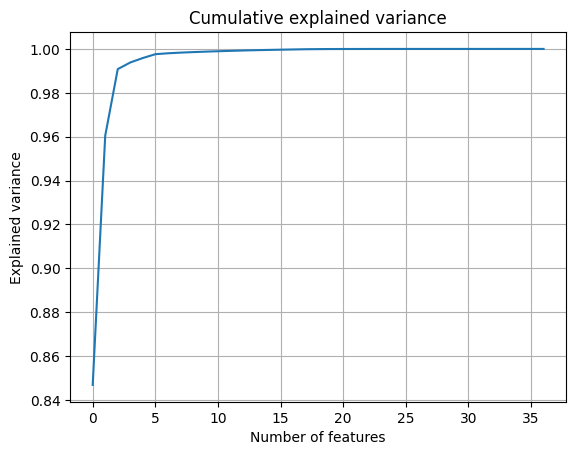

Explained variance with 5 features:  0.9958474393044456


In [8]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)
explained_variance = pca.explained_variance_ratio_
acc_sum = np.cumsum(explained_variance) 

plt.title('Cumulative explained variance')
plt.plot(acc_sum)
plt.grid()
plt.ylabel('Explained variance')
plt.xlabel('Number of features')
plt.show()

print('Explained variance with 5 features: ', acc_sum[4])

In [65]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

def fit_linear_reg(X,Y):
    model_k = linear_model.LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared

def fit_knn_reg(X, Y):
    from sklearn import neighbors
    model_k = neighbors.KNeighborsRegressor()
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared

### Forward selection + Cross Validation

In [8]:

r2 = [] 
features = []
n_features = []

for k in tnrange(1,len(X.columns) + 1, desc = 'Treating columns'):
	r2_tmp = []
	for new_feat in X_train.columns:
		if new_feat in features: continue
		new_features = features.copy()
		new_features.append(new_feat)
		metrics = fit_linear_reg(X_train[new_features],y_train)
		metrics = fit_knn_reg(X_train[new_features], y_train)   
		r2_tmp.append((metrics[1], new_feat))                 
	r2.append(sorted(r2_tmp, key=lambda x: x[0])[-1][0])	
	new_feat = sorted(r2_tmp, key=lambda x: x[0])[-1][1]
	features.append(new_feat)
	n_features.append(len(features))   

df = pd.DataFrame({'n_features': n_features,'R2': r2,'features':features})

Treating columns:   0%|          | 0/37 [00:00<?, ?it/s]

NameError: name 'rss' is not defined

In [10]:
df = pd.DataFrame({'n_features': n_features,'R2': r2,'features':features})

,n_features,R2,features
0,1,0.216546,Latitude
1,2,0.434535,Accomodates
2,3,0.472355,Entire home/apt
3,4,0.502095,Bathrooms
4,5,0.511985,Loft
5,6,0.520958,Longitude
6,7,0.528055,Apartment
7,8,0.536292,Location Rating
8,9,0.542842,Guests Included
9,10,0.545458,Accuracy Rating


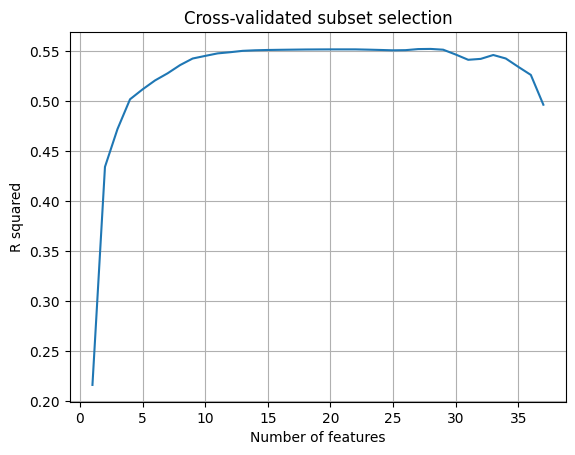

In [11]:
plt.title('Cross-validated subset selection')
plt.xlabel('Number of features')
plt.ylabel('R squared')
plt.grid()
plt.plot(df['n_features'], df['R2'])
plt.show()


### Autoencoder

In [12]:
from sklearn.neural_network import MLPRegressor

n_input = X_train.columns

n_encoder1 = 50
n_encoder2 = 30

n_latent = 2

n_decoder2 = 30
n_decoder1 = 50

In [13]:
reg = MLPRegressor(hidden_layer_sizes = (n_encoder1, n_encoder2, n_latent, n_decoder2, n_decoder1), 
                   activation = 'tanh', 
                   solver = 'adam', 
                   learning_rate_init = 1e-4, 
                   max_iter = 100, 
                   tol = 0.0000001, 
                   verbose = False)

In [14]:
reg.fit(X_train, y_train)

/home/victor/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(activation='tanh', hidden_layer_sizes=(50, 30, 2, 30, 50),
             learning_rate_init=0.0001, max_iter=100, tol=1e-07)

In [15]:
def encoder(data):
    data = np.asmatrix(data)
    
    encoder1 = data*reg.coefs_[0] + reg.intercepts_[0]
    encoder1 = (np.exp(encoder1) - np.exp(-encoder1))/(np.exp(encoder1) + np.exp(-encoder1))
    
    encoder2 = encoder1*reg.coefs_[1] + reg.intercepts_[1]
    encoder2 = (np.exp(encoder2) - np.exp(-encoder2))/(np.exp(encoder2) + np.exp(-encoder2))
    
    latent = encoder2*reg.coefs_[2] + reg.intercepts_[2]
    latent = (np.exp(latent) - np.exp(-latent))/(np.exp(latent) + np.exp(-latent))
    
    return np.asarray(latent)

test_latent = encoder(X_train)


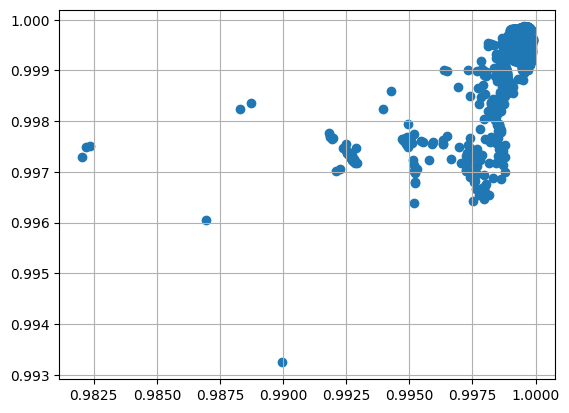

In [16]:
plt.scatter(test_latent[:, 0], test_latent[:, 1])
plt.grid()
plt.show()

# Model selection

In [24]:
# import sklearn.linear_model
import sklearn.svm
import sklearn.neural_network
# import sklearn.ensemble
import sklearn.neighbors

#model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=5)

# #model = sklearn.linear_model.Ridge()
model = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(10,3), activation='relu')
#model = sklearn.svm.SVR(kernel='poly')
# model = sklearn.ensemble.RandomForestRegressor()

model.fit(X_train, y_train)
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)


# import xgboost as xgb
# param = {'max_depth':5, 'eta':1, 'objective':'reg:squarederror' }
# num_round = 2

# dtrain = xgb.DMatrix(X_train, label=y_train)
# dtest = xgb.DMatrix(X_test, label=y_test)

# bst = xgb.train(param, dtrain, num_round)
# y_train_predict = bst.predict(dtrain)
# y_test_predict = bst.predict(dtest)

#from lazypredict.Supervised import LazyRegressor
# reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None)
# reg.fit(X_train, X_test, y_train, y_test)




# evaluation
train_mse = sklearn.metrics.mean_squared_error(y_train, y_train_predict)
train_r2 = sklearn.metrics.r2_score(y_train, y_train_predict)
print("Train MSE: "+str(train_mse))
print("Train R2: "+str(train_r2))

test_mse = sklearn.metrics.mean_squared_error(y_test, y_test_predict)
test_r2 = sklearn.metrics.r2_score(y_test, y_test_predict)
print("Test MSE: "+str(test_mse))
print("Test R2: "+str(test_r2))




In [101]:
y_test - y_test_predict

13964    13.432511
6105    -13.281156
9001     -5.677313
12335   -31.224319
11237     4.764753
           ...    
1956    -17.298526
10375    -4.126278
3972    -11.257448
5302    -16.109106
96      -32.127213
Name: Price, Length: 3122, dtype: float64